# Analysis of chemo diversity on pharmacological and biological activities

The [dataset](results/activities_2022-01-29_16-33-05.csv) is obtained from the Scopus downloader version 2.0 from the [base set](data/activities.csv) of chemical compounds and activities.

**TODO** check:

- <https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe>
- <https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#multiindex-query-syntax>


## Loading data obtained from Scopus

### Boilerplate

Some Python configuration.


In [1]:
from pathlib import Path
from itertools import islice, product
from pprint import pprint
import dataclasses

import pandas as pd
import numpy as np
import numpy.typing as npt
from scipy import linalg


import seaborn as sns
import matplotlib.pyplot as plt

# BUG sous linux avec Python 3.10
# import holoviews as hv
# We do it by ourselves
# import prince

import biblio_extractor as bex

np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 20)
pd.set_option("display.min_rows", 10)

# (11.7, 8.27) = A4 landscape
sns.set_theme(style="dark", palette="muted", font_scale=1.10, rc={"figure.figsize": (16.54, 11.7)})


DATASET_FILENAME = Path("results/activities_2022-01-29_16-33-05.csv")
# DATASET_FILENAME = Path("results/samples_2022-02-09_17-12-54.csv")
print(f"{DATASET_FILENAME.stem = } {DATASET_FILENAME.suffix = }")


DATASET_FILENAME.stem = 'activities_2022-01-29_16-33-05' DATASET_FILENAME.suffix = '.csv'


### Loading the CSV file

Now, we load the dataset we'll use in this Notebook. It is generated using [our tool](biblio_extractor.py) in the same repository.
The dataset is a 106 \* 66 matrix, with rows and columns indexed by three levels (using Pandas's `MultiIndex`) as follows:

- level 0 is _class_ (chemical, biological or pharmacological class)
- level 1 is _name_ (compound or activity, a.k.a. keyword)
- level 2 is _kind_ (either _w/o_ for _without_ or _w/_ for _with_)

The matrix is indexed by _two_ disjoint finite sets of keywords:

- **rows**: a set of 53 (chemical) coumpounds = {acridine, triterpene, ...}
- **columns**: a set of 33 (biological, pharmacological) activities = {germination, cytotoxicity, ...}

An example is shown below, restricted to two compounds and two activities.
Note that this is **not** an extract of the whole dataset, the (w/o, w/o) cells being smaller here.

|                   |            |     | germination | germination | cytotoxicity | cytotoxicity |
| ----------------- | ---------- | --- | ----------- | ----------- | ------------ | ------------ |
|                   |            |     | allelopathy | allelopathy | pharmaco     | pharmaco     |
|                   |            |     | w/o         | w/          | w/o          | w/           |
| alkaloid          | acridine   | w/o | 2100        | 32          | 28           | 2104         |
| alkaloid          | acridine   | w/  | 1294        | 11          | 9            | 1296         |
| terpenoid/terpene | triterpene | w/o | 1283        | 11          | 9            | 1285         |
| terpenoid/terpene | triterpene | w/  | 2111        | 32          | 28           | 2115         |

Let $M$ be this matrix, and for each couple of keywords made of a compound and and activity, call $M_{ij} = (c_i, a_j)$, the **ij confusion submatrix**.
Assume that $M_{ij}$ is of the form :
\begin{bmatrix}
FF & FT\\
TF & TT
\end{bmatrix}

Where :

- $FF = (\text{w/o}, \text{w/o})$ is the number of papers that have **neither** the $c_i$ compound **nor** the $a_j$ activity;
- $FT = (\text{w/o}, \text{w/})$ is the number of papers that have the $a_j$ activity but **not** the $c_i$ compound;
- $TF = (\text{w/}, \text{w/o})$ is the number of papers that have the $c_i$ compound but **not** the $a_j$ activity;
- $TT = (\text{w/}, \text{w/})$ is the number of papers that have **both** the $c_i$ compound **and** the $a_j$ activity.

We avoid the open world hypothesis by restricting the analysis to the paper in the domain $D$,
which is the set of papers that have at least one compound and one activity.
By construction:

- $FF + FT$ and $TF + TT$ are constants for each $c_i$ (whatever the choice of $a_j$) and is the total number of papers in $D$ with the $c_i$ comppound;
- $FF + TF$ and $FT + TT$ are constants for each $a_j$ (whatever the choice of $c_i$) and is the total number of papers in $D$ with the $a_j$ activity.
- thus each confusion matrix $M_{ij}$ is such that $FF + FT + TF + TT = |D|$ where $|D|$ is _the total number of paper_ under scrutiny.


In [3]:
dataset = pd.read_csv(DATASET_FILENAME, index_col=[0, 1, 2], header=[0, 1, 2])
# dataset.index.names = ["class", "name", "with"]
# dataset.columns.names = ["class", "name", "with"]

all_compounds = set(dataset.index.get_level_values(1))
all_activities = set(dataset.columns.get_level_values(1))

sort_order = [True, True, False]
dataset.sort_index(axis=1, inplace=True, ascending=sort_order)
dataset.sort_index(axis=0, inplace=True, ascending=sort_order)

dataset

abiotic         \
                                                          antioxidant          
                                                                  w/o     w/   
alkaloid          acridine                            w/o      179092  62176   
                                                      w/         2430    266   
                  benzylamine                         w/o      180754  62371   
                                                      w/          768     71   
                  colchicine                          w/o      175968  62250   
...                                                               ...    ...   
terpenoid/terpene sesterterpene                       w/          182      7   
                  tetraterpene/carotenoid/xanthophyll w/o      178534  54855   
                                                      w/         2988   7587   
                  triterpene                          w/o      177099  61285   
                                                      w/         4423   1157   

                                                                         \
                                                          drought         
                                                              w/o    w/   
alkaloid          acridine                            w/o  240191  1077   
                                                      w/     2694     2   
                  benzylamine                         w/o  242046  1079   
                                                      w/      839     0   
                  colchicine                          w/o  237143  1075   
...                                                           ...   ...   
terpenoid/terpene sesterterpene                       w/      189     0   
                  tetraterpene/carotenoid/xanthophyll w/o  232655   734   
                                                      w/    10230   345   
                  triterpene                          w/o  237308  1076   
                                                      w/     5577     3   

                                                                   ...  \
                                                            metal  ...   
                                                              w/o  ...   
alkaloid          acridine                            w/o  216324  ...   
                                                      w/     2439  ...   
                  benzylamine                         w/o  218089  ...   
                                                      w/      674  ...   
                  colchicine                          w/o  213101  ...   
...                                                           ...  ...   
terpenoid/terpene sesterterpene                       w/      189  ...   
                  tetraterpene/carotenoid/xanthophyll w/o  208780  ...   
                                                      w/     9983  ...   
                  triterpene                          w/o  213234  ...   
                                                      w/     5529  ...   

                                                          pharmaco          \
                                                          sedative   wound   
                                                                w/     w/o   
alkaloid          acridine                            w/o     2483  234561   
                                                      w/         8    2619   
                  benzylamine                         w/o     2485  236360   
                                                      w/         6     820   
                  colchicine                          w/o     2457  231656   
...                                                            ...     ...   
terpenoid/terpene sesterterpene                       w/         1     187   
                  tetraterpene/carotenoid/xanthophyll w/o     2488  22670

### Extractiong the "old" "w/, w/" matrix

We can extract the "old" 53\*33 matrix we use in the version version of this software, where we had only the with/with queries.
In our small running example, that would be:

|                   |            | germination | cytotoxicity |
| ----------------- | ---------- | ----------- | ------------ |
|                   |            | allelopathy | pharmaco     |
| alkaloid          | acridine   | 11          | 1296         |
| terpenoid/terpene | triterpene | 32          | 2115         |


In [4]:
with_with_matrix = dataset.xs("w/", level=2).xs("w/", level=2, axis=1)
with_with_matrix

abiotic          \
                                                      antioxidant drought   
alkaloid          acridine                                    266       2   
                  benzylamine                                  71       0   
                  colchicine                                  192       4   
                  cyclopeptide                                 57       1   
                  imidazole                                  1082       8   
...                                                           ...     ...   
terpenoid/terpene polyterpene                                   0       0   
                  sesquiterpene                               863      17   
                  sesterterpene                                 7       0   
                  tetraterpene/carotenoid/xanthophyll        7587     345   
                  triterpene                                 1157       3   

                                                                        ...  \
                                                      metal  salt   uv  ...   
alkaloid          acridine                              257   163   80  ...   
                  benzylamine                           165    80   23  ...   
                  colchicine                             84   187   20  ...   
                  cyclopeptide                          168    35   16  ...   
                  imidazole                            2507  1195  302  ...   
...                                                     ...   ...  ...  ...   
terpenoid/terpene polyterpene                             0     0    0  ...   
                  sesquiterpene                          72    59   39  ...   
                  sesterterpene                           0     3    0  ...   
                  tetraterpene/carotenoid/xanthophyll   592   513  392  ...   
                  triterpene                             51    59   46  ...   

                                                      pharmaco             \
                                                       obesity rheumatism   
alkaloid          acridine                                   3          0   
                  benzylamine                               34          0   
                  colchicine                               172         19   
                  cyclopeptide                              45          7   
                  imidazole                                297          1   
...                                                        ...        ...   
terpenoid/terpene polyterpene                                0          0   
                  sesquiterpene                             49          0   
                  sesterterpene                              1          0   
                  tetraterpene/carotenoid/xanthophyll      418          1   
                  triterpene                               127          2   

                                                                     toxicity  
                                                      sedative wound toxicity  
alkaloid          acridine                                   8    77      402  
                  benzylamine                                6    19      102  
                  colchicine                                34   222      866  
                  cyclopeptide                               4    51      171  
                  imidazole                                486   460     1768  
...                                                        ...   ...      ...  
terpenoid/terpene polyterpene                                0     0        2  
                  sesquiterpene                             30   124      341  
                  sesterterpene                              1     2       12  
                  tetraterpene/carotenoid/xanthophyll        3    97      828  
                  triterpene                                22   2

### Sanity checks

We do some sanity checks explained earlier :

- the name (level 2 of rows/columns) are _unique_
- the sum of each confusion submatrixes is _constant_ and is the total number of papers $|D|$, here 243 964.


In [5]:
# sanity check #1
assert dataset.shape == (2 * len(all_compounds), 2 * len(all_activities))
dataset


# sanity check : group by summing on level 2 on both rows and cols produce a matrix of constants : the number of papers
submatrix_sum = dataset.groupby(level=1).sum().groupby(level=1, axis=1).sum()
number_of_papers = np.unique(submatrix_sum.values)
# if the Scopus collection did not evolve during while querying
assert len(number_of_papers) == 1

number_of_papers = number_of_papers[0]
print(f"The domain contains {number_of_papers} papers")

with_with_total = with_with_matrix.values.sum()
print(
    f"Total number of positive/positive occurrences is {with_with_total} for {number_of_papers} papers (average={with_with_total/number_of_papers})"
)


The domain contains 243964 papers
Total number of positive/positive occurrences is 383330 for 243964 papers (average=1.571256414880884)


## Analysing data

### Extracting the confusion submatrixes

Lets illustrate the content of this table. The **2 by 2 confusion submatrix** about _acridine_ and _cytotoxicity_ is as follows.


In [12]:
acridine_cytotoxicity_submatrix = dataset.loc[
    (
        "alkaloid",
        "acridine",
    ),
    (
        "pharmaco",
        "cytotoxicity",
    ),
]
print(f"Among {number_of_papers} papers, there are")
for i, j in product(bex.SELECTORS, bex.SELECTORS):
    print(f"- {acridine_cytotoxicity_submatrix.loc[i,j]} papers {i} acridine and {j} cytotoxicity in their keywords")

print("The acridine and cytotoxicity confusion matrix is as follows")
acridine_cytotoxicity_submatrix


Among 243964 papers, there are
- 202039 papers w/o acridine and w/o cytotoxicity in their keywords
- 39229 papers w/o acridine and w/ cytotoxicity in their keywords
- 1400 papers w/ acridine and w/o cytotoxicity in their keywords
- 1296 papers w/ acridine and w/ cytotoxicity in their keywords
The acridine and cytotoxicity confusion matrix is as follows


,w/o,w/
w/o,202039,39229
w/,1400,1296


### Marginal sums

We compute marginal sums on rows and cols and add them to the orginial dataset.

**NOTE** we actually should do the other way around, that is to query Scopue for margin and for all (w/, w/) cells and _then_ fill in the missing ones.

In [8]:
margin_idx = (bex.CLASS_SYMB, bex.MARGIN_SYMB, bex.SELECTORS[1])
margin_cols = dataset.groupby(level=1).sum().drop_duplicates().reset_index(drop=True)
margin_cols.index = pd.MultiIndex.from_tuples([margin_idx])
margin_cols

abiotic                               ... pharmaco                \
       antioxidant        drought         metal  ... sedative   wound         
               w/o     w/     w/o    w/     w/o  ...       w/     w/o    w/   
* Σ w/      181522  62442  242885  1079  218763  ...     2491  237180  6784   

       toxicity         
       toxicity         
            w/o     w/  
* Σ w/   217898  26066  

[1 rows x 66 columns]

In [9]:

margin_rows = dataset.groupby(level=1, axis=1).sum().iloc[:, 0]
margin_rows.name = margin_idx
margin_rows = pd.DataFrame(margin_rows)

margin_rows
# dataset_margins = dataset.copy()
# dataset_margins[margin_idx] = margin_rows
# dataset_margins = pd.concat([dataset_margins, margin_cols]).fillna(number_of_papers).astype(int)

# dataset_margins


*
                                                                Σ
                                                               w/
alkaloid          acridine                            w/o  241268
                                                      w/     2696
                  benzylamine                         w/o  243125
                                                      w/      839
                  colchicine                          w/o  238218
...                                                           ...
terpenoid/terpene sesterterpene                       w/      189
                  tetraterpene/carotenoid/xanthophyll w/o  233389
                                                      w/    10575
                  triterpene                          w/o  238384
                                                      w/     5580

[106 rows x 1 columns]

### Aggregating submatrixes to a scalar

The <https://en.wikipedia.org/wiki/Confusion_matrix> can be equipped with _a lot_ of different metrics (or score) that aggregate the $2 \times 2$ matrix to a single scalar value.
One of the best is the <https://en.wikipedia.org/wiki/Phi_coefficient>

However, we are not exactly in the context of a confusion table. Moreover we do not have argument to provilege one metric over another. So we explore a part of the space.

#### Some metrics

We may analyze the "influence" of each margin to the score to design our own

In [11]:
def tt_projection_metric(arr):
    """The trivial one. Just keep the bottom right cell. Amount to compute on "the old matrix" """
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT

# def intersection_metric(arr):
#     """The trivial one. Just keep the bottom right cell. Amount to compute on "the old matrix" """
#     [FF, FT], [TF, TT] = arr.reshape(2, 2)
#     return TT / (FF + FT + TF + TT)


def row_implication_metric(arr):
    """The % of paper that have both keywords among the first one. Values add to 1 row wise"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (TF + TT)


def col_implication_metric(arr):
    """The % of paper that have both keywords among the second one. Values add to 1 col wise"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FT + TT)


def fowlkes_mallows_metric(arr):
    """Computes the Fowlkes-Mallows index: sqrt(the product of row and col implication)"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / np.sqrt((FT + TT) * (TF + TT))


def accuracy_metric(arr):
    """Computes the accuracy"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (TT + FF) / (FF + FT + TF + TT)


def x_metric(arr):
    """Some another one by our own"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (FF + TT - FT - TF) / (FF + FT + TF + TT)


def fraction_metric(arr):
    """The % of paper that have both keywords among the ones having at least one."""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FT + TF - TT)


metrics = [
    tt_projection_metric,
    row_implication_metric,
    col_implication_metric,
    fowlkes_mallows_metric,
    # accuracy_metric, # CHECK if BUG
    # x_metric,        # CHECK if BUG
    fraction_metric,
]


print("An example on the acridine/cytotoxicity submatrix, its score for each metric")
print(acridine_cytotoxicity_submatrix)

for metric in metrics:
    print(f"- {metric.__name__:<22} = {metric(acridine_cytotoxicity_submatrix.values)}")


An example on the acridine/cytotoxicity submatrix, its score for each metric
        w/o     w/
w/o  202039  39229
w/     1400   1296
- tt_projection_metric   = 1296
- row_implication_metric = 0.4807121661721068
- col_implication_metric = 0.03198025909932141
- fowlkes_mallows_metric = 0.12398911091858036
- fraction_metric        = 0.03294943177484555


**Remark** we'd love to say that "acridine  _partly implies_ cytotoxicity " ! Among 33 activities, about 48% of papers about acridine are about cytotoxicity !
**Important** look for implication rules ?

### Applying the metrics

First, we have some fun with Numpy

In [13]:
# redimension the values to a 4D array
C, A = len(all_compounds), len(all_activities)
print(C, A)
M_2_2 = np.moveaxis(dataset.values.reshape((C, 2, A, 2)), 1, -2)
# 1D is easier for apply_along_axis
M_4 = M_2_2.reshape((C * A, 4))

print(f"{M_2_2.shape = }")
print(f"{M_4.shape = }")

# M.sum(axis=(2,3)) or similarly
np_nb_paper = np.sum(M_2_2, axis=(2, 3), keepdims=False)
print(f"{np.all(np_nb_paper == number_of_papers) = } (with {number_of_papers = })")


53 33
M_2_2.shape = (53, 33, 2, 2)
M_4.shape = (1749, 4)
np.all(np_nb_paper == number_of_papers) = True (with number_of_papers = 243964)


In [22]:
THRESHOLD = 1
mask_ff = (M_4 >= THRESHOLD).all(axis=1)
mask_4 = np.repeat(mask_ff, 4, axis = 0).reshape((C,A,2,2))
mask_CA = np.moveaxis(mask_4,2,1).reshape((C*2, A*2))


In [23]:
filtered = dataset.copy()
filtered[~mask_CA] = np.nan
filtered = filtered.dropna(axis = 1).dropna(axis = 0)
filtered

filtered = dataset

We obtain the same as submatrix_sum


In [25]:
score_df = {}
C2, A2 = len(filtered.index) // 2, len(filtered.columns) // 2
print(C2, A2)
values = np.moveaxis(filtered.values.reshape((C2, 2, A2, 2)), 1, -2).reshape((C2 * A2, 4))
print(values.shape)
# print(values)
# print(pd.MultiIndex.from_tuples(filtered.index.droplevel(2)))

subfiltered = filtered.xs("w/", level=2).xs("w/", level=2, axis=1)

for metric in metrics:
    metric_name = metric.__name__
    matrix = np.apply_along_axis(metric, 1, values).reshape((C2, A2))
    # print(matrix.shape)

    score_df[metric_name] = pd.DataFrame(matrix, index=subfiltered.index, columns=subfiltered.columns)
    # print(score_df)
    filename = Path(f"{DATASET_FILENAME.stem}_{metric_name}{DATASET_FILENAME.suffix}")
    score_df[metric_name].to_csv(Path("results") / filename)


scores_summary_df = pd.DataFrame.from_dict(
    {f_name: [df.values.min(), df.values.mean(), df.values.max(), df.values.std()] for f_name, df in score_df.items()},
    orient="index",
    columns=["min", "mean", "max", "std"],
)


scores_summary_df


53 33
(1749, 4)


,min,mean,max,std
tt_projection_metric,0.000,219.171,27855.000,1081.415
row_implication_metric,0.000,0.038,1.000,0.081
col_implication_metric,0.000,0.022,0.583,0.050
fowlkes_mallows_metric,0.000,0.018,0.504,0.035
fraction_metric,0.000,0.008,0.957,0.036


### Correspondance Analysis

Here, we implement Correspondance Analysis from scratch using SVD from from `scipy.linalg`.
We explore the results on all previous metrics.

In [26]:
# sanity checks
def sanity_scores(all_dfs):
    for metric_name, df in all_dfs.items():
        # The input matrix: the dataset after a metric is applied
        M = df.values
        N = np.sum(M)
        # Z is M normalised
        Z = M / N
        print(f"{metric_name} (grand total {N = })")

        R = np.sum(M, axis=1)  # X @ np.ones(X.shape[1])
        C = np.sum(M, axis=0)  # Z @ np.ones(X.shape[0])

        print(f"    {np.sum(R) = :.4f} and {np.sum(C) = :.4f}")

        r = np.sum(Z, axis=1)
        c = np.sum(Z, axis=0)
        # print(f"    {r[:, np.newaxis].shape = } {c[:, np.newaxis].shape = }")
        print(
            f"    {np.sum(r) = :.4f} and {np.sum(c) = :.4f}"
        )  # \n{100*r = } \n{100*c = }


sanity_scores(score_df)

tt_projection_metric (grand total N = 383330)
    np.sum(R) = 383330.0000 and np.sum(C) = 383330.0000
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
row_implication_metric (grand total N = 65.7895272917367)
    np.sum(R) = 65.7895 and np.sum(C) = 65.7895
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
col_implication_metric (grand total N = 38.764363443794124)
    np.sum(R) = 38.7644 and np.sum(C) = 38.7644
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
fowlkes_mallows_metric (grand total N = 31.23157570524735)
    np.sum(R) = 31.2316 and np.sum(C) = 31.2316
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
fraction_metric (grand total N = 14.778185526117818)
    np.sum(R) = 14.7782 and np.sum(C) = 14.7782
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000


In [27]:
def normalize(df, *, method="laplace"):
    M = df.values
    # normalize by grand total
    Z = M / np.sum(M)
    # margins
    r = np.sum(Z, axis=1)
    c = np.sum(Z, axis=0)
    # Dc = np.diag(c)
    # Dr = np.diag(r)
    # center Z
    Zc = Z - (r[:, np.newaxis] @ (c[:, np.newaxis].T))
    # normalize
    if method == "laplace":
        S = np.diag(r ** (-0.5)) @ Zc @ np.diag(c ** (-0.5))
    elif method == "rows":
        S = np.diag(r ** (-1)) @ Zc
    elif method == "cols":
        S = Zc @ np.diag(c ** (-1))
    else:
        raise ValueError(f"unknown normalization {method = }")

    return S, r, c


for metric_name, matrix in score_df.items():
    S, r, c = normalize(matrix, method="laplace")
    print(f"{metric_name} {S.shape}, margins:")
    # print(S)
    print(f"rows sum is {np.sum(S, axis=1).sum()}\n{np.sum(S, axis=1)}")
    print(f" cols sum is {np.sum(S, axis=0).sum()}\n{np.sum(S, axis=0)}")


tt_projection_metric (53, 33), margins:
rows sum is 0.975385759124804
[-0.0141  0.0227  0.1352  0.0869  0.1013  0.0759  0.0174  0.0249  0.0879
  0.0123  0.0221  0.0139  0.1372  0.0719  0.0801  0.1284  0.0072  0.0378
  0.0289  0.0399  0.0109  0.0495  0.0251  0.0725  0.0342  0.004  -0.0041
 -0.0395 -0.2416 -0.0013 -0.026  -0.0136 -0.2169 -0.0639  0.0378 -0.0699
 -0.0834 -0.0359 -0.0182 -0.0076  0.0642  0.0276  0.0121  0.1107  0.008
  0.0505  0.0995  0.0232 -0.0022  0.0955 -0.01   -0.0398  0.0061]
 cols sum is 0.9753857591248044
[-0.5901  0.1177 -0.1521  0.0796 -0.1046  0.0528  0.0124  0.0946  0.0299
  0.0409  0.0355  0.0132  0.0462  0.0098 -0.0081  0.0172  0.1045 -0.0242
  0.0691 -0.0529  0.1552 -0.0848  0.0699  0.1968  0.1936 -0.0301  0.1168
  0.4415  0.0406  0.0074 -0.0063 -0.0179  0.1012]
row_implication_metric (53, 33), margins:
rows sum is 0.015783114449157382
[-0.0639  0.0319  0.0919  0.0936  0.0357  0.0153  0.0673 -0.0074  0.0803
  0.0665  0.003   0.0803  0.1136  0.0294  0.1014  0

In [28]:
# the number of dimensions we project onto
NAXIS = 2
NEXAMPLES = 10

# TODO use the standard scipy API
@dataclasses.dataclass
class CA:
    rows_coordinates: npt.NDArray
    cols_coordinates: npt.NDArray
    inertias: npt.NDArray


def correspondence_analysis(df) -> CA:

    # normalize
    S, r, c = normalize(df, method="laplace")
    # decompose
    U, D, Vt = linalg.svd(S)
    # diagonal of sqrt of "eigenvalues"
    Da = np.eye(U.shape[0], Vt.shape[0]) * D

    # print(f"{ U.shape,  D.shape, Da.shape, Vt.shape = }")

    # SVD ensures that Vt  @ Vt.T == I == U.T @ U
    assert np.allclose(Vt @ Vt.T, np.identity(Vt.shape[0]))
    assert np.allclose(U.T @ U, np.identity(U.shape[0]))

    # BUG/TODO : this depends on the normalization method !
    r_std_coords = np.diag(r ** (-0.5)) @ U
    r_coords = r_std_coords @ Da
    # print(f"{r_coords.shape}, first {NEXAMPLES} : {r_coords[:NEXAMPLES, NAXIS]}")

    c_std_coords = np.diag(c ** (-0.5)) @ Vt.T
    c_coords = c_std_coords @ Da.T
    # print(f"{c_coords.shape}, first {NEXAMPLES} : {c_coords[:NEXAMPLES, NAXIS]}")

    # smallest dimension
    K = min(S.shape)
    principal_inertias = np.diag(Da) ** 2
    # print(f"(eigenvalues) {principal_inertias = }")

    total_inertia = np.trace(S @ S.T)
    # print(f"{total_inertia = }")

    explained_inertias = 100 * principal_inertias / total_inertia
    # print(f"(in %) {explained_inertias = }")

    return CA(r_coords, c_coords, principal_inertias)


for m_name, df in score_df.items():
    res = correspondence_analysis(df)
    print(m_name)
    print(f"    total inertia {res.inertias.sum()} ({res.inertias.shape})")
    print(
        f"    explained inertias on first {NAXIS} axis (%) = {100*res.inertias[:NAXIS].sum()/res.inertias.sum():.4f} {100*res.inertias[:NAXIS]/res.inertias.sum()}"
    )


tt_projection_metric
    total inertia 0.6768601446110586 ((33,))
    explained inertias on first 2 axis (%) = 52.5342 [34.2743 18.2599]
row_implication_metric
    total inertia 1.213574590857688 ((33,))
    explained inertias on first 2 axis (%) = 34.8698 [17.9887 16.8811]
col_implication_metric
    total inertia 1.5098879411451194 ((33,))
    explained inertias on first 2 axis (%) = 34.2811 [19.7614 14.5197]
fowlkes_mallows_metric
    total inertia 1.1359045817440263 ((33,))
    explained inertias on first 2 axis (%) = 30.0285 [18.8789 11.1496]
fraction_metric
    total inertia 2.0917442140638465 ((33,))
    explained inertias on first 2 axis (%) = 34.8782 [19.75   15.1283]


### Graphical representation of compounds on the first two axis

Now, we draw compounds and activities as scatterplots on the first 2 dimensions.

In [29]:
import numbers


def data_to_ca(df, r_coords, c_coords, axis=None):
    # r_coords, c_coords, inertias = dataclasses.astuple(correspondence_analysis(df))

    if axis is None:
        axis = [0, 1]
    elif isinstance(axis, numbers.Number):
        axis = [axis]
    else:
        raise TypeError(f"cannot convert axis type {axis}")

    dfs = []
    if 0 in axis:
        rows_ca = pd.DataFrame(index=df.index.droplevel())
        rows_ca["1st axis"] = r_coords[:, 0]
        rows_ca["2nd axis"] = -r_coords[:, 1]
        rows_ca["class"] = df.index.droplevel(1)
        rows_ca["mass"] = np.sum(df.values, axis=1)
        rows_ca["type"] = "Compound"
        dfs.append(rows_ca)

    if 1 in axis:
        cols_ca = pd.DataFrame(index=df.columns.droplevel())
        cols_ca["1st axis"] = c_coords[:, 0]
        cols_ca["2nd axis"] = -c_coords[:, 1]
        cols_ca["class"] = df.columns.droplevel(1)
        cols_ca["mass"] = np.sum(df.values, axis=0)
        cols_ca["type"] = "Activity"
        dfs.append(cols_ca)

    full_ca = pd.concat(dfs, axis=0)
    return full_ca


# df = score_df["tt_projection_metric"]
# ca_res = correspondence_analysis(df)
# plot_ca = data_to_ca(df, ca_res.rows_coordinates, ca_res.cols_coordinates, axis=None)
# plot_ca


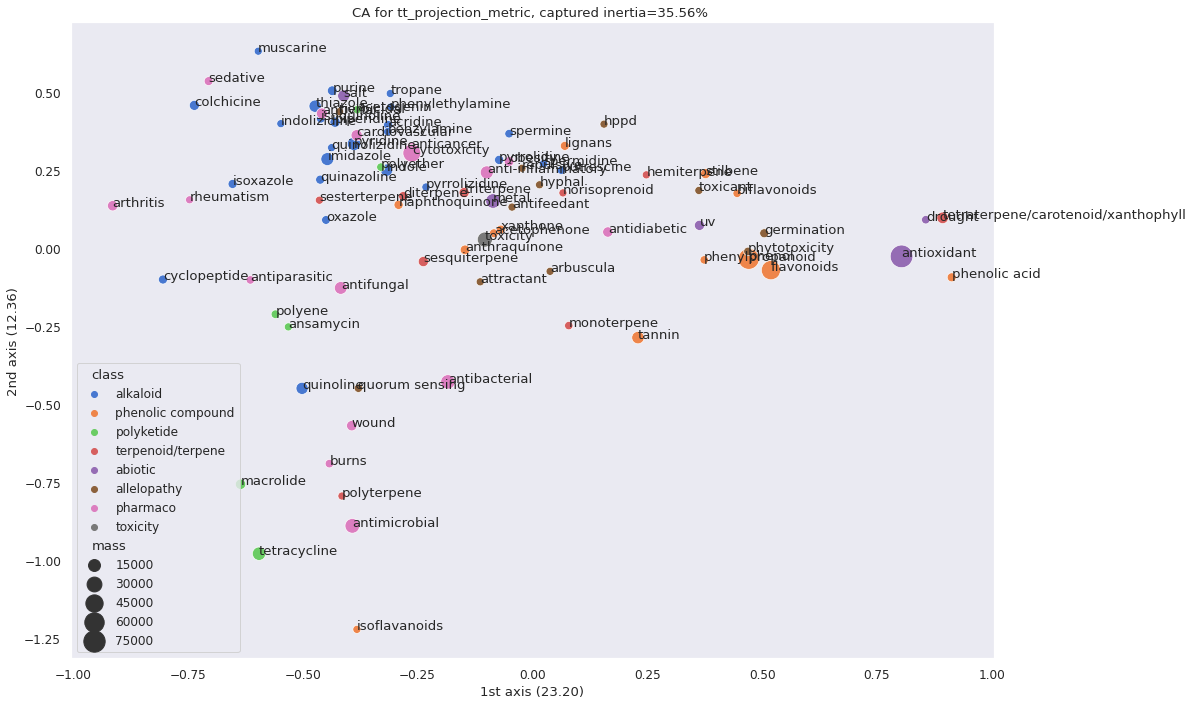

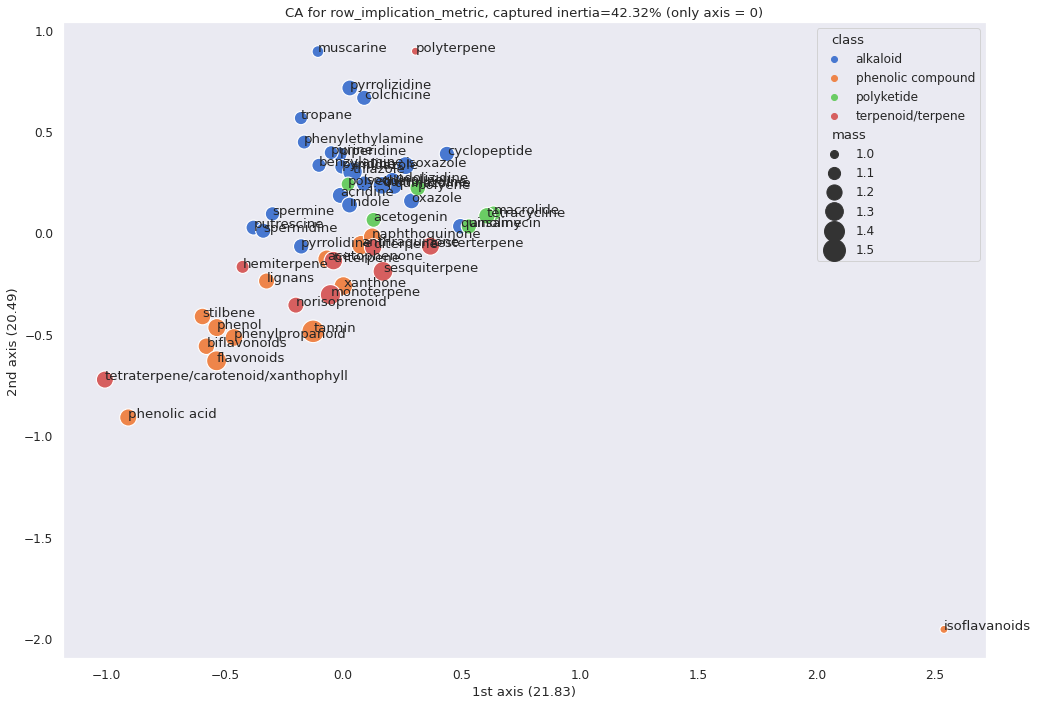

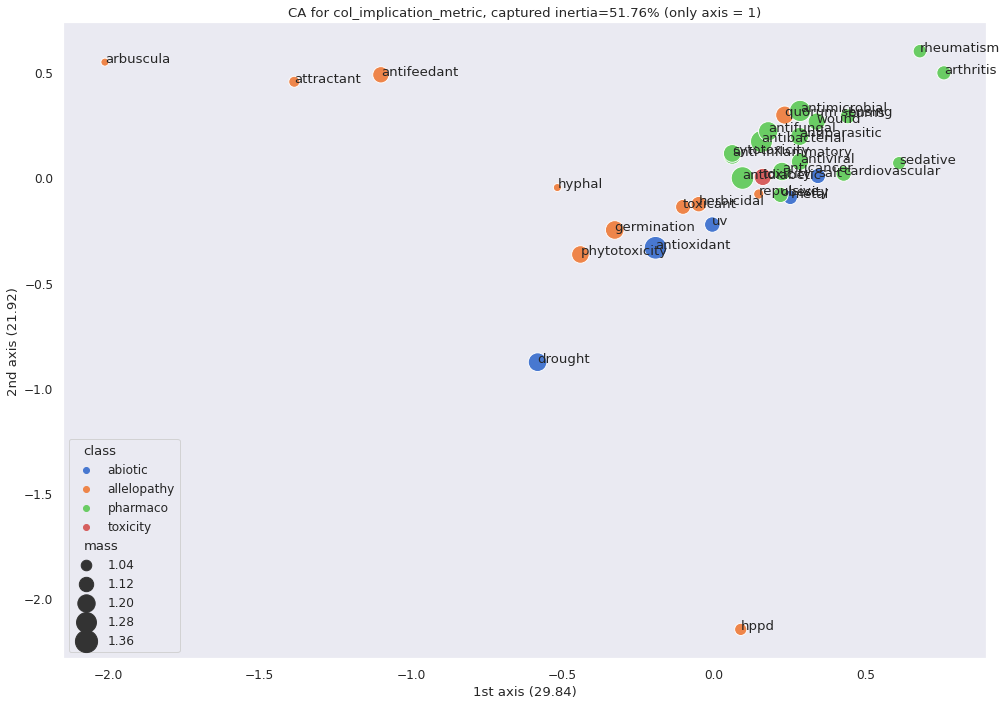

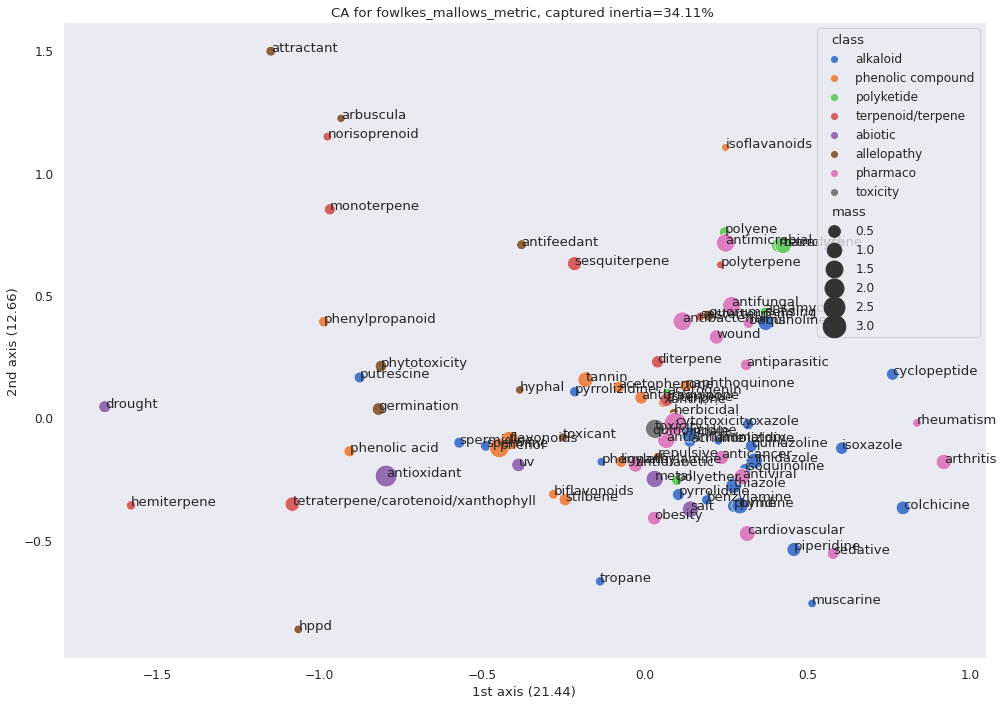

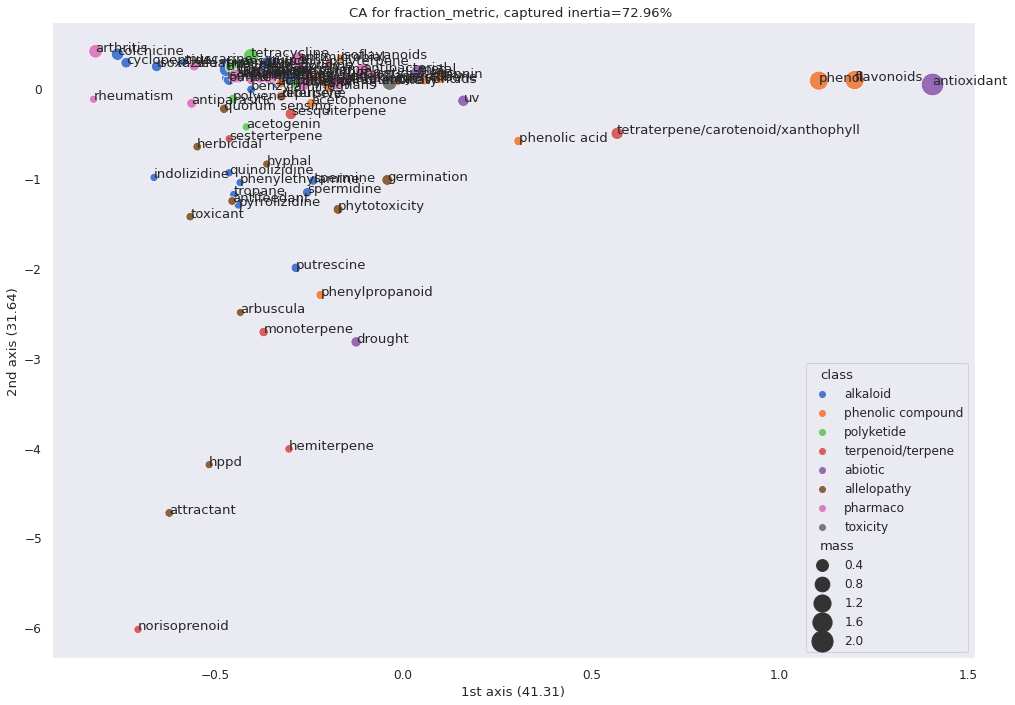

In [30]:
SHIFT = 0.00

for f_name, df in score_df.items():
    ca_res = correspondence_analysis(df)
    axis = None
    if f_name == "row_implication_metric":
        axis = 0
    if f_name == "col_implication_metric":
        axis = 1
    plot_ca = data_to_ca(df, ca_res.rows_coordinates, ca_res.cols_coordinates, axis=axis)

    ax = sns.scatterplot(data=plot_ca, x="1st axis", y="2nd axis", hue="class", size="mass", sizes=(64, 512))
    ax.set_title(
        f"CA for {f_name}, captured inertia={100*ca_res.inertias[:2].sum():.2f}% {f'(only {axis = })' if axis is not None else ''}"
    )
    ax.set_xlabel(f"1st axis ({100*ca_res.inertias[0]:.2f})")
    ax.set_ylabel(f"2nd axis ({100*ca_res.inertias[1]:.2f})")
    for index, row in plot_ca.iterrows():
        ax.annotate(index, (row["1st axis"] + SHIFT, row["2nd axis"] + SHIFT))
    plt.show()


In [31]:
def clean_implications(axis=0):
    if axis == 0:
        f_name = "row_implication_metric"
    elif axis == 1:
        f_name = "col_implication_metric"
    else:
        raise IndexError(f"no such axis {axis}")

    df = score_df[f_name].copy()
    df_support = (
        score_df["tt_projection_metric"]
        .melt(ignore_index=False, value_name="value")
        .reset_index()
        .drop(columns=["level_0", "variable_0"], axis=1)
        .rename(columns={"level_1": "compound", "variable_1": "activity"})
        .set_index(["compound", "activity"])
    )

    df.index = df.index.droplevel(0)
    df.columns = df.columns.droplevel(0)
    df = df.melt(ignore_index=False, value_name="%").reset_index()
    df.set_index(["index", "variable"], inplace=True)
    df.index.set_names(["compound", "activity"], inplace=True)
    df["mass"] = df_support["value"]
    # df["support"] = df_support["value"] / df["%"]
    df.sort_values(by="%", ascending=False, inplace=True)
    return df


# clean_implications(axis = 0)


In [32]:
print("Best implication rules : compound => activity")
clean_implications(0).head(15)


Best implication rules : compound => activity


,,%,mass
compound,activity,,
isoflavanoids,antibacterial,1.000,2
phenolic acid,antioxidant,0.759,1825
acetogenin,cytotoxicity,0.724,228
tetraterpene/carotenoid/xanthophyll,antioxidant,0.717,7587
pyrrolizidine,toxicity,0.675,469
polyterpene,toxicity,0.667,2
polyene,antifungal,0.636,909
flavonoids,antioxidant,0.617,25763
sesterterpene,cytotoxicity,0.598,113


In [33]:
print("Best implication rule : activity => compound")
clean_implications(1).swaplevel().head(15)

Best implication rule : activity => compound


%   mass
activity      compound                                        
toxicant      phenol                              0.583     70
arbuscula     sesquiterpene                       0.455      5
antioxidant   phenol                              0.446  27855
              flavonoids                          0.413  25763
uv            phenol                              0.398   2614
repulsive     phenol                              0.367     22
phytotoxicity phenol                              0.335    413
antidiabetic  flavonoids                          0.334   1967
sedative      pyridine                            0.326    811
drought       tetraterpene/carotenoid/xanthophyll 0.320    345
germination   phenol                              0.320    782
salt          thiazole                            0.314   4202
antimicrobial tetracycline                        0.312   6811
burns         tetracycline                        0.309    371
metal         phenol                              0.309   7791

## Vizualizing data

### Using Sankey diagrams

In [34]:
import holoviews as hv

hv.extension("bokeh")
# hv.extension('matplotlib')

sankey_data = (
    score_df["tt_projection_metric"]
    .melt(ignore_index=False, value_name="weight")
    .reset_index()
    .drop(columns=["level_0", "variable_0"])
    .rename(columns={"level_1": "compound", "variable_1": "activity"})
    .fillna(0)
)


sankey_threshold = number_of_papers // 100
print(
    f"filtering couples (compound, activity) that have at least {sankey_threshold} papers (out of {number_of_papers})"
)

# https://holoviews.org/reference_manual/holoviews.plotting.bokeh.html#sankey-module
sankey_values = sankey_data[sankey_data["weight"] > sankey_threshold]
sankey_diagram = hv.Sankey(sankey_values.values)
sankey_diagram.opts(label_position="outer", width=1200, height=800)


ImportError: cannot import name 'url' from 'django.conf.urls' (/home/romulus/.local/lib/python3.10/site-packages/django/conf/urls/__init__.py)

In [ ]:
compounds_classes_graph = (
    margin_rows.xs("w/", level=2).reset_index().rename(columns={"level_0": "c-class", "level_1": "compound"})
)

activities_classes_graph = (
    margin_cols.transpose()
    .xs("w/", level=2)
    .swaplevel()
    .reset_index()
    .rename(columns={"level_1": "a-class", "level_0": "activity"})
)
# renommage pour éviter les éponymes
compounds_classes_graph["c-class"] = compounds_classes_graph["c-class"].astype(str) + "(class)"
# renommage pour éviter les éponymes
activities_classes_graph["a-class"] = activities_classes_graph["a-class"].astype(str) + "(class)"

# de toutes les classes, on ne garde que celles au dessus du seuil
c_class = compounds_classes_graph[compounds_classes_graph["compound"].isin(sankey_values["compound"])]
a_class = activities_classes_graph[activities_classes_graph["activity"].isin(sankey_values["activity"])]

sankey = hv.Sankey(c_class.values.tolist() + sankey_values.values.tolist() + a_class.values.tolist())
sankey.opts(width=1200, height=800,  node_color='index')
